In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seml
import pandas as pd
import json
from collections import defaultdict
from functools import reduce
import seaborn as sns
from itertools import product
from scipy.stats import binned_statistic
from matplotlib.lines import Line2D
import os.path as osp
import pickle
from tqdm import tqdm
import torch

In [2]:
%cd ../..

/nfs/homedirs/fuchsgru/MastersThesis


In [3]:
import data.constants as dc

In [4]:
SETTING = 'Setting'
RESIDUAL = 'Residual'
ACCURACY = 'Accuracy'
ECE = 'Expected Calibration Error'
WEIGHT_SCALE = 'Weight Scale'
LIPSCHITZ = 'Median Empirical Lipschitz Constant'
LIPSCHITZ_MAX = 'Empirical Upper Lipschitz Constant'
LIPSCHITZ_MIN = 'Empirical Lower Lipschitz Constant'
OOD = 'Out of Distribution Setting'
PROXY = 'Proxy'
LOC = 'Leave out Classes'
BERNOULLI = 'Bernoulli'
NORMAL = 'Normal'
GPC = 'Feature Density'
MAX_SCORE = 'Max Score'
AUROC = 'AUC-ROC'
TRANSDUCTIVE = 'Transductive'
HYBRID = 'Hybrid'
NO_EDGES = 'Remove Edges'

MODEL = 'Model'

MUTUAL_INFORMTION = 'Mutual Information'
PREDICTED_CLASS_VARIANCE = 'Predictive Variance'
EXPECTED_SOFTMAX_ENTROPY = 'Expected Softmax Entropy'

ALEATORIC = 'Aleatoric'
EPISTEMIC = 'Epistemic'
NA = 'n./a.'


In [5]:
ENSEMBLE = 'Ensemble'
DROPOUT = 'Dropout'
DROP_EDGE = 'Drop Edge'
DROPOUT_AND_DROP_EDGE = 'Dropout &\nDrop Edge'
GPN = 'Graph Posterior\nNetwork'
VGCN = 'GCN'
VGCN_LIPSCHITZ = 'GCN &\nLipschitzness'

PPR_DISTANCE = 'PPR Distance\nto Train'
INPUT_DISTANCE = 'Min. Input Distance\nto Train'


In [6]:
baselines = {} # Aggregate all results here

### Ensemble of GCNs

In [7]:
collection_name_ensemble = 'week15_ensemble'
collection_ensemble = seml.database.get_collection(collection_name_ensemble)
experiments_ensemble = [{'config' : r['config'], 'result' : r['result']['results'], 'id' : r['_id']} for r in collection_ensemble.find() if r['status'] in ('COMPLETED',)]

print(f'Number of finished experiments : {len(experiments_ensemble)}')

Number of finished experiments : 100


In [8]:
results_ensemble = []
for ex in experiments_ensemble:
    config = ex['config']
    metrics = {}
    for k, vs in ex['result'].items():
        if len(vs) != 1:
            raise RuntimeError(f'{k} : {vs}')
        v = vs[0]
        if isinstance(v, dict):
            v = v['value']
        metrics[k] = v
    
    base = {
        SETTING : {dc.TRANSDUCTIVE : TRANSDUCTIVE, dc.HYBRID : HYBRID}[config['data']['setting']],
        LIPSCHITZ : metrics['empirical_lipschitz_val_slope_median_perturbation_noise'],
        LIPSCHITZ_MAX : metrics['empirical_lipschitz_val_slope_max_perturbation_noise'],
        LIPSCHITZ_MIN : metrics['empirical_lipschitz_val_slope_min_perturbation_noise'],
        MODEL : ENSEMBLE,
        
    }
    results_ensemble.append({
        ECE : metrics['ece_val'],
        ACCURACY : metrics['accuracy_val'],
    } | base)
    for k, v in metrics.items():
        if '-no-edges' in k or '_no-edges' in k:
            k = k.replace('-no-edges', '').replace('_no-edges', '')
            no_edges = True
        else:
            no_edges = False
        
        # AUROCs
        if not 'auroc' in k:
            continue
        if k.endswith('loc'):
            ood = LOC
        elif k.endswith('ber'):
            ood = BERNOULLI
        elif k.endswith('normal'):
            ood = NORMAL
        
        if 'mutual-information' in k:
            proxy = MUTUAL_INFORMTION
            continue
        elif 'expected-softmax-entropy' in k:
            proxy = EXPECTED_SOFTMAX_ENTROPY
            proxy = ALEATORIC
        elif 'predicted-class-variance' in k:
            proxy = PREDICTED_CLASS_VARIANCE
            proxy = EPISTEMIC
        else:
            continue
            
        results_ensemble.append({
            AUROC : v,
            PROXY : proxy,
            OOD : ood,
            NO_EDGES : no_edges
        } | base)

### Dropout, Drop Edge

In [9]:
collection_name_dropout = 'week15_dropout'
collection_dropout = seml.database.get_collection(collection_name_dropout)
experiments_dropout = [{'config' : r['config'], 'result' : r['result']['results'], 'id' : r['_id']} for r in collection_dropout.find() if r['status'] in ('COMPLETED',)]

print(f'Number of finished experiments : {len(experiments_dropout)}')

Number of finished experiments : 300


In [10]:
results_dropout = []
for ex in experiments_dropout:
    config = ex['config']
    metrics = {}
    for k, vs in ex['result'].items():
        if len(vs) != 1:
            raise RuntimeError(f'{k} : {vs}')
        v = vs[0]
        if isinstance(v, dict):
            v = v['value']
        metrics[k] = v
    
    if config['model']['dropout'] > 0 and config['model']['drop_edge'] > 0:
        model = DROPOUT_AND_DROP_EDGE
    elif config['model']['dropout'] > 0:
        model = DROPOUT
    elif config['model']['drop_edge'] > 0:
        model = DROP_EDGE
    else:
        raise ValueError
    
    base = {
        SETTING : {dc.TRANSDUCTIVE : TRANSDUCTIVE, dc.HYBRID : HYBRID}[config['data']['setting']],
        LIPSCHITZ : metrics['empirical_lipschitz_val_slope_median_perturbation_noise'],
        LIPSCHITZ_MAX : metrics['empirical_lipschitz_val_slope_max_perturbation_noise'],
        LIPSCHITZ_MIN : metrics['empirical_lipschitz_val_slope_min_perturbation_noise'],
        MODEL : model,
        
    }
    results_dropout.append({
        ECE : metrics['ece_val'],
        ACCURACY : metrics['accuracy_val'],
    } | base)
    for k, v in metrics.items():
        if '-no-edges' in k or '_no-edges' in k:
            k = k.replace('-no-edges', '').replace('_no-edges', '')
            no_edges = True
        else:
            no_edges = False
        
        # AUROCs
        if not 'auroc' in k:
            continue
        if k.endswith('loc'):
            ood = LOC
        elif k.endswith('ber'):
            ood = BERNOULLI
        elif k.endswith('normal'):
            ood = NORMAL
        
        if 'mutual-information' in k:
            proxy = MUTUAL_INFORMTION
            continue
        elif 'expected-softmax-entropy' in k:
            proxy = EXPECTED_SOFTMAX_ENTROPY
            proxy = ALEATORIC
        elif 'predicted-class-variance' in k:
            proxy = PREDICTED_CLASS_VARIANCE
            proxy = EPISTEMIC
        else:
            continue
            
        results_dropout.append({
            AUROC : v,
            PROXY : proxy,
            OOD : ood,
            NO_EDGES : no_edges
        } | base)
            

In [11]:
config['model']

{'activation': 'leaky_relu',
 'drop_edge': 0.5,
 'dropout': 0.5,
 'freeze_residual_projection': False,
 'hidden_sizes': [64],
 'leaky_relu_slope': 0.01,
 'model_type': 'gcn',
 'residual': False,
 'use_bias': True,
 'use_spectral_norm': False,
 'use_spectral_norm_on_last_layer': False,
 'weight_scale': 1.0}

### GPN

In [12]:
%pwd

'/nfs/homedirs/fuchsgru/MastersThesis'

In [13]:
results_gpn = []
for setting, setting_prefix in ((TRANSDUCTIVE, 'transductive'), (HYBRID, 'hybrid')):
    for ood, ood_prefix in ((LOC, 'loc'), (BERNOULLI, 'bernoulli'), (NORMAL, 'normal')):
        results_path = osp.join('..', 'Graph-Posterior-Network', 'saved_experiments', 'CoraFullMLvsOS', f'{setting_prefix}-{ood_prefix}', 'results.pkl')
        if not osp.exists(results_path):
            print('Path', results_path, 'doesnt exist')
            continue
        with open(results_path, 'rb') as f:
            results = pickle.load(f)
            base = {
                SETTING : setting,
                OOD: ood,
                MODEL: GPN,
            }
            for auroc in results['val_ood_detection_epistemic_auroc_val']:
                results_gpn.append(base | {
                    AUROC : auroc,
                    PROXY : EPISTEMIC,
                    NO_EDGES : False,
                })
            for auroc in results['val_ood_detection_features_auroc_val']:
                results_gpn.append(base | {
                    AUROC : auroc,
                    PROXY : EPISTEMIC,
                    NO_EDGES : True,
                })
            for auroc in results['val_ood_detection_aleatoric_auroc_val']:
                results_gpn.append(base | {
                    AUROC : auroc,
                    PROXY : ALEATORIC,
                    NO_EDGES : False,
                })
            for acc, ece in zip(results['val_accuracy_val'], results['val_ECE_val']):
                results_gpn.append(base | {
                    ACCURACY : acc,
                    ECE : ece,
                })
            


### Parameterless Baselines

In [14]:
%pwd

'/nfs/homedirs/fuchsgru/MastersThesis'

In [15]:
import scipy.sparse as sp
from sklearn.metrics import roc_auc_score

In [16]:
results_baselines = []
for setting, setting_prefix in ((TRANSDUCTIVE, 'transductive'), (HYBRID, 'hybrid')):
    for split_idx in tqdm(range(5)):
        for ood, ood_prefix, dataset_name in (
            (LOC, 'left-out-classes', 'ood-val'), 
            (BERNOULLI, 'perturbations', 'ood-val-ber'), 
            (NORMAL, 'perturbations', 'ood-val-normal')):
            
            path = osp.join('.exported_datasets', 'cora_full', f'{setting_prefix}-{ood_prefix}', f'split-{split_idx}.pkl')
            with open(path, 'rb') as f:
                storage = pickle.load(f)['data']

            data_train = storage['train']
            data_ood = storage[dataset_name]
            
            # Rebuild the train mask on ood data
            vertex_idx_train = {v for v, idx in data_train.vertex_to_idx.items() if data_train.mask[idx]}
            mask_train = np.zeros(data_ood.x.size(0), dtype=bool)
            for v in vertex_idx_train:
                mask_train[data_ood.vertex_to_idx[v]] = True
            mask_train = torch.Tensor(mask_train).bool()
            
            
            # Parameterless baseline: Distance to training data in input space
            x_train = data_ood.x[mask_train]
            x_eval = data_ood.x[data_ood.mask & data_ood.auroc_mask]
            min_dist = torch.cdist(x_eval, x_train).min(-1)[0]
            auroc = roc_auc_score(
                data_ood.is_in_distribution[data_ood.mask & data_ood.auroc_mask].numpy(),
                -min_dist.numpy(),
            )
            for no_edges in (True, False):
                results_baselines.append({
                    SETTING : setting,
                    OOD : ood,
                    MODEL : INPUT_DISTANCE,
                    PROXY : NA,
                    AUROC : auroc,
                    NO_EDGES : no_edges,
                })
            
            
            # Parameterless baseline: appnp diffusion of the training mask
            n_ood = data_ood.x.size(0)
            A = sp.coo_matrix((np.ones(data_ood.edge_index.size(1)), data_ood.edge_index.numpy()), shape=(n_ood, n_ood))
            degrees = A.sum(axis=0)[0].tolist()
            D = sp.diags(degrees, [0])
            D = D.power(-0.5)
            A_hat = D.dot(A).dot(D)
            
            
            def approximate_personalized_pagerank(A, alpha=0.2, n_iter=10):
                n = A.shape[0]
                A = A.tocsr()
                ppr = np.ones((n, n)) / n
                for _ in range(n_iter):
                    ppr = (alpha * np.eye(n)) + ((1 - alpha) * (A @ ppr))
                return ppr
            pi = approximate_personalized_pagerank(A_hat)
            train_diffused = torch.tensor(pi @ mask_train.float().numpy())
            
            auroc = roc_auc_score(
                data_ood.is_in_distribution[data_ood.mask & data_ood.auroc_mask].numpy(),
                train_diffused[data_ood.mask & data_ood.auroc_mask].numpy(),
            )
            results_baselines.append({
                SETTING : setting,
                OOD : ood,
                MODEL : PPR_DISTANCE,
                PROXY : NA,
                AUROC : auroc,
                NO_EDGES : False,
            })
        
        


100%|██████████| 5/5 [00:55<00:00, 11.19s/it]


In [17]:
results_baselines

[{'Setting': 'Transductive',
  'Out of Distribution Setting': 'Leave out Classes',
  'Model': 'Min. Input Distance\nto Train',
  'Proxy': 'n./a.',
  'AUC-ROC': 0.7121400601251325,
  'Remove Edges': True},
 {'Setting': 'Transductive',
  'Out of Distribution Setting': 'Leave out Classes',
  'Model': 'Min. Input Distance\nto Train',
  'Proxy': 'n./a.',
  'AUC-ROC': 0.7121400601251325,
  'Remove Edges': False},
 {'Setting': 'Transductive',
  'Out of Distribution Setting': 'Leave out Classes',
  'Model': 'PPR Distance\nto Train',
  'Proxy': 'n./a.',
  'AUC-ROC': 0.9645736566313206,
  'Remove Edges': False},
 {'Setting': 'Transductive',
  'Out of Distribution Setting': 'Bernoulli',
  'Model': 'Min. Input Distance\nto Train',
  'Proxy': 'n./a.',
  'AUC-ROC': 0.020100502512562814,
  'Remove Edges': True},
 {'Setting': 'Transductive',
  'Out of Distribution Setting': 'Bernoulli',
  'Model': 'Min. Input Distance\nto Train',
  'Proxy': 'n./a.',
  'AUC-ROC': 0.020100502512562814,
  'Remove Edges':

### Feature Density - GCN

In [18]:
collection_name_gcn = 'week12_spectral_norm_cora_ml'
collection_gcn = seml.database.get_collection(collection_name_gcn)
experiments_gcn = [{'config' : r['config'], 'result' : r['result'], 'id' : r['_id']} for r in collection_gcn.find() if r['status'] in ('COMPLETED',)]
for ex in experiments_gcn:
    with open(ex['result']) as f:
        ex['result'] = json.load(f)

print(f'Number of finished experiments : {len(experiments_gcn)}')

Number of finished experiments : 152


In [19]:
experiments_gcn_vanilla = [ex for ex in experiments_gcn if ex['config']['model']['use_spectral_norm'] == False and ex['config']['model']['residual'] == False]
len(experiments_gcn_vanilla)

4

In [20]:
experiments_gcn_lipschitz = [ex for ex in experiments_gcn if ex['config']['model']['use_spectral_norm'] == True and ex['config']['model']['residual'] == True 
                             and ex['config']['model']['weight_scale'] == 1.0 and ex['config']['model']['use_spectral_norm_on_last_layer'] == False]
len(experiments_gcn_lipschitz)

4

In [21]:
results_gcn = []
for model, exs in ((VGCN, experiments_gcn_vanilla), (VGCN_LIPSCHITZ, experiments_gcn_lipschitz)):
    for ex in exs:
        config = ex['config']
        base = {
            SETTING : {dc.TRANSDUCTIVE : TRANSDUCTIVE, dc.HYBRID : HYBRID}[config['data']['setting']],
            LIPSCHITZ : metrics['empirical_lipschitz_val_slope_median_perturbation_noise'],
            LIPSCHITZ_MAX : metrics['empirical_lipschitz_val_slope_max_perturbation_noise'],
            LIPSCHITZ_MIN : metrics['empirical_lipschitz_val_slope_min_perturbation_noise'],
            MODEL : model,
        }
        if config['data']['ood_type'] == 'left-out-classes':
            oods = ((LOC, 'loc'),)
        elif config['data']['ood_type'] == 'perturbations':
            oods = ((BERNOULLI, 'ber'), (NORMAL, 'normal'))
        else:
            raise ValueError(config['data']['ood_type'])
        
        for ood, suffix in oods:
            for no_edges, edge_suffix in ((True, '-no-edges'), (False, '')):
                for v in ex['result'][f'auroc_gpc-diag-weighted:no_{suffix}{edge_suffix}']:
                    results_gcn.append(base | {
                        AUROC : v,
                        PROXY : EPISTEMIC,
                        OOD : ood,
                        NO_EDGES : no_edges,
                    })
                for v in ex['result'][f'auroc_max-score_{suffix}{edge_suffix}']:
                    results_gcn.append(base | {
                        AUROC : v,
                        PROXY : ALEATORIC,
                        OOD : ood,
                        NO_EDGES : no_edges,
                    })
                for acc, ece in zip(ex['result']['accuracy_val'], ex['result']['ece_val']):
                    results_gcn.append(base | {
                        ACCURACY : acc,
                        ECE : ece,
                    })
            
        

In [22]:
all_results = results_ensemble + results_dropout + results_gpn + results_gcn + results_baselines

In [23]:
df = pd.DataFrame(all_results)

In [24]:

order = [ENSEMBLE, DROPOUT, DROP_EDGE, DROPOUT_AND_DROP_EDGE, GPN, VGCN, VGCN_LIPSCHITZ, PPR_DISTANCE, INPUT_DISTANCE]

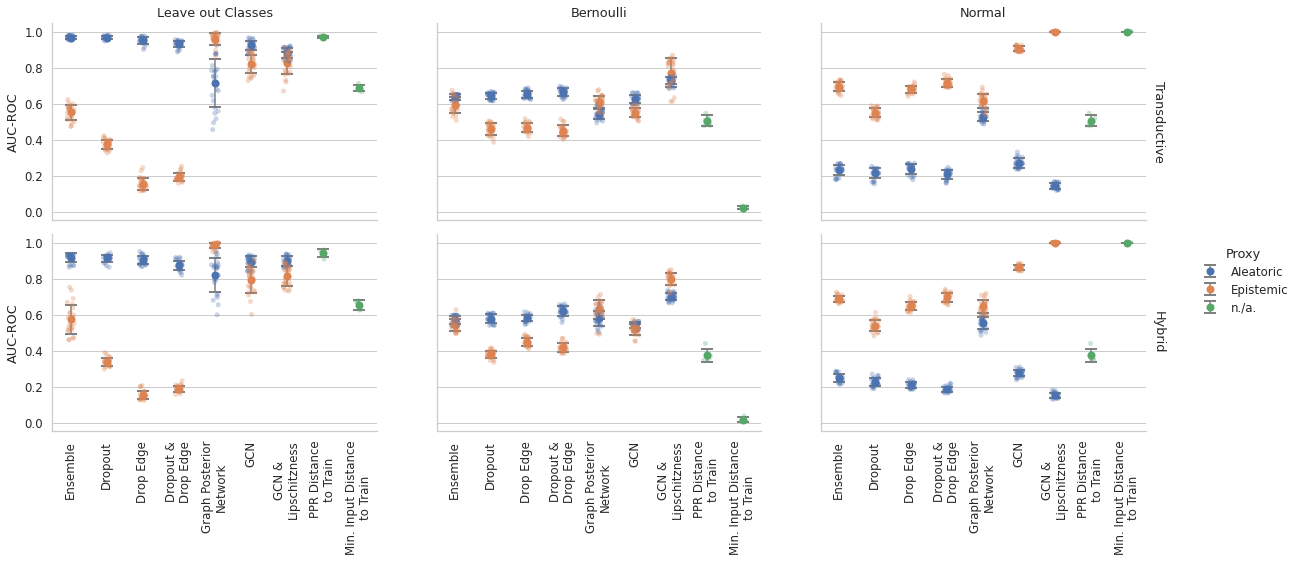

In [25]:
sns.set(context='notebook', font_scale=1.07)
sns.set_style("whitegrid")
grid = sns.FacetGrid(
    data = df[df[NO_EDGES] == False],
    row = SETTING,
    col = OOD,
    hue = PROXY,
    height=3.5,
    aspect=1.6,
    margin_titles=True,
)

artists = {}

def plot_y(x, y, color=None, label=None):
    sns.stripplot(x=x, y=y, color=color, label=label, alpha=0.3, order=order)
    # mean = pd.DataFrame({'x' : x, 'y' : y}).groupby('x').mean()
    # sns.stripplot(data=mean.reset_index(), x='x', y='y', color=color, label=label, order=order, size=8, 
    #               jitter=False, marker='X', edgecolor='black', linewidth=0)
    _x, _y, _yerr = [], [], []
    for idx, xx in enumerate(order):
        _x.append(idx)
        _y.append(y[x == xx].mean())
        _yerr.append(y[x == xx].std())
        
    artists[label] = (plt.errorbar(_x, _y, yerr = _yerr, color=color, ecolor='grey', mew=2, fmt='o', ms=6, capsize=6, label=label))
    
    
grid.map(plot_y, MODEL, AUROC)
for axes in grid.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
    
grid.set_titles(row_template = '{row_name}', col_template = '{col_name}')
grid.set_axis_labels("")
grid.add_legend(artists)

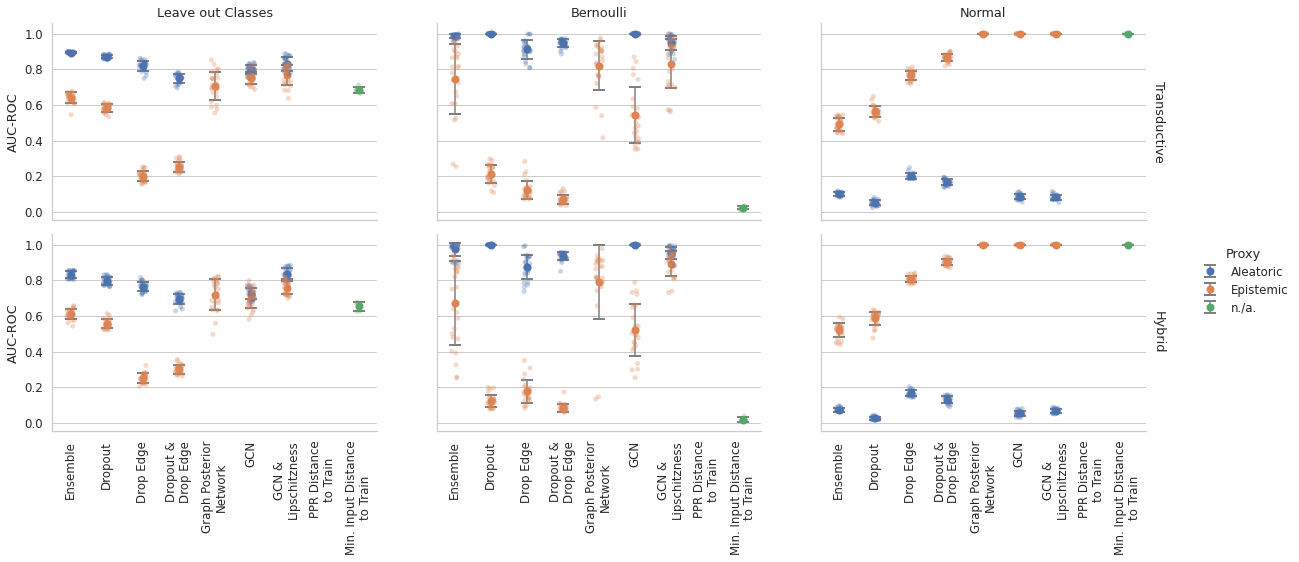

In [26]:
sns.set(context='notebook', font_scale=1.07)
sns.set_style("whitegrid")
grid = sns.FacetGrid(
    data = df[df[NO_EDGES] == True],
    row = SETTING,
    col = OOD,
    hue = PROXY,
    height=3.5,
    aspect=1.6,
    margin_titles=True,
)

artists = {}

def plot_y(x, y, color=None, label=None):
    sns.stripplot(x=x, y=y, color=color, label=label, alpha=0.3, order=order)
    # mean = pd.DataFrame({'x' : x, 'y' : y}).groupby('x').mean()
    # sns.stripplot(data=mean.reset_index(), x='x', y='y', color=color, label=label, order=order, size=8, 
    #               jitter=False, marker='X', edgecolor='black', linewidth=0)
    _x, _y, _yerr = [], [], []
    for idx, xx in enumerate(order):
        _x.append(idx)
        _y.append(y[x == xx].mean())
        _yerr.append(y[x == xx].std())
        
    artists[label] = (plt.errorbar(_x, _y, yerr = _yerr, color=color, ecolor='grey', mew=2, fmt='o', ms=6, capsize=6, label=label))
    
    
grid.map(plot_y, MODEL, AUROC)
for axes in grid.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
    
grid.set_titles(row_template = '{row_name}', col_template = '{col_name}')
grid.set_axis_labels("")
grid.add_legend(artists)

(150,) (150,) (0.2980392156862745, 0.4470588235294118, 0.6901960784313725) Aleatoric
(175,) (175,) (0.8666666666666667, 0.5176470588235295, 0.3215686274509804) Epistemic
(5,) (5,) (0.3333333333333333, 0.6588235294117647, 0.40784313725490196) n./a.
(150,) (150,) (0.2980392156862745, 0.4470588235294118, 0.6901960784313725) Aleatoric
(175,) (175,) (0.8666666666666667, 0.5176470588235295, 0.3215686274509804) Epistemic
(5,) (5,) (0.3333333333333333, 0.6588235294117647, 0.40784313725490196) n./a.
(150,) (150,) (0.2980392156862745, 0.4470588235294118, 0.6901960784313725) Aleatoric
(175,) (175,) (0.8666666666666667, 0.5176470588235295, 0.3215686274509804) Epistemic
(5,) (5,) (0.3333333333333333, 0.6588235294117647, 0.40784313725490196) n./a.
(150,) (150,) (0.2980392156862745, 0.4470588235294118, 0.6901960784313725) Aleatoric
(175,) (175,) (0.8666666666666667, 0.5176470588235295, 0.3215686274509804) Epistemic
(5,) (5,) (0.3333333333333333, 0.6588235294117647, 0.40784313725490196) n./a.
(150,) (

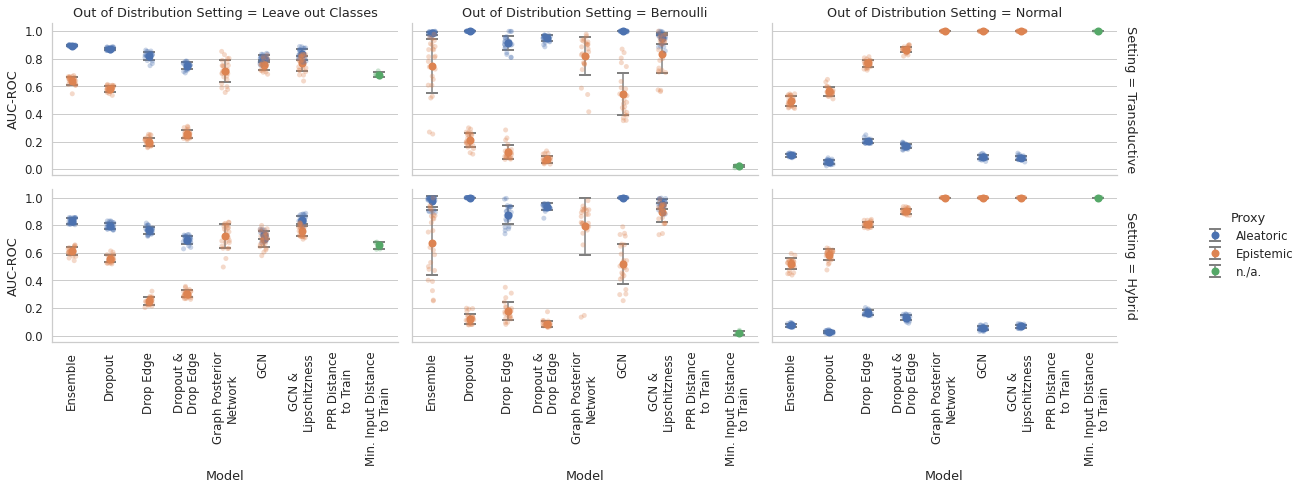

In [27]:

def func(x, y, color=None, label=None):
    print(x.shape, y.shape, color, label)
grid.map(func, MODEL, AUROC)

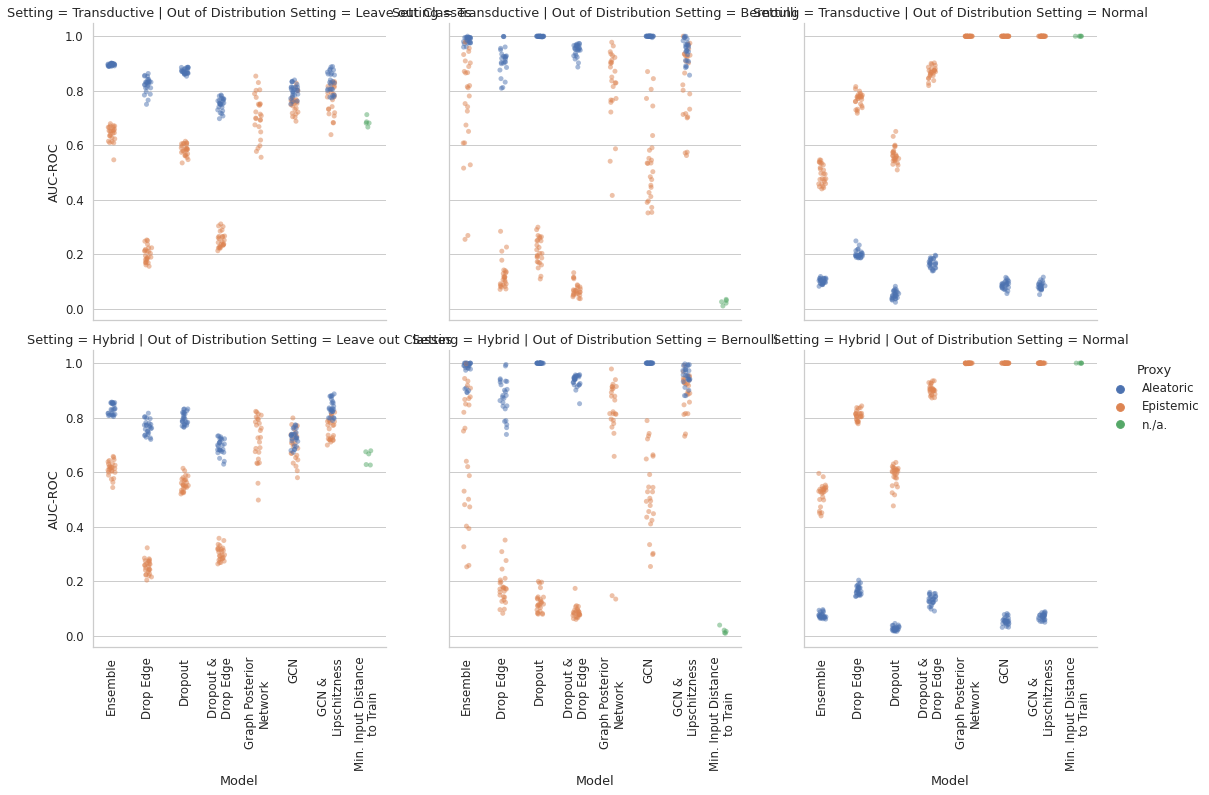

In [28]:
grid = sns.catplot(data = df[df[NO_EDGES] == True], x = MODEL, y=AUROC, hue=PROXY, row=SETTING, col=OOD, 
                  alpha=.5,  facet_kws = {'margin_titles' : True}, sharex=True, sharey = True)
for axes in grid.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)

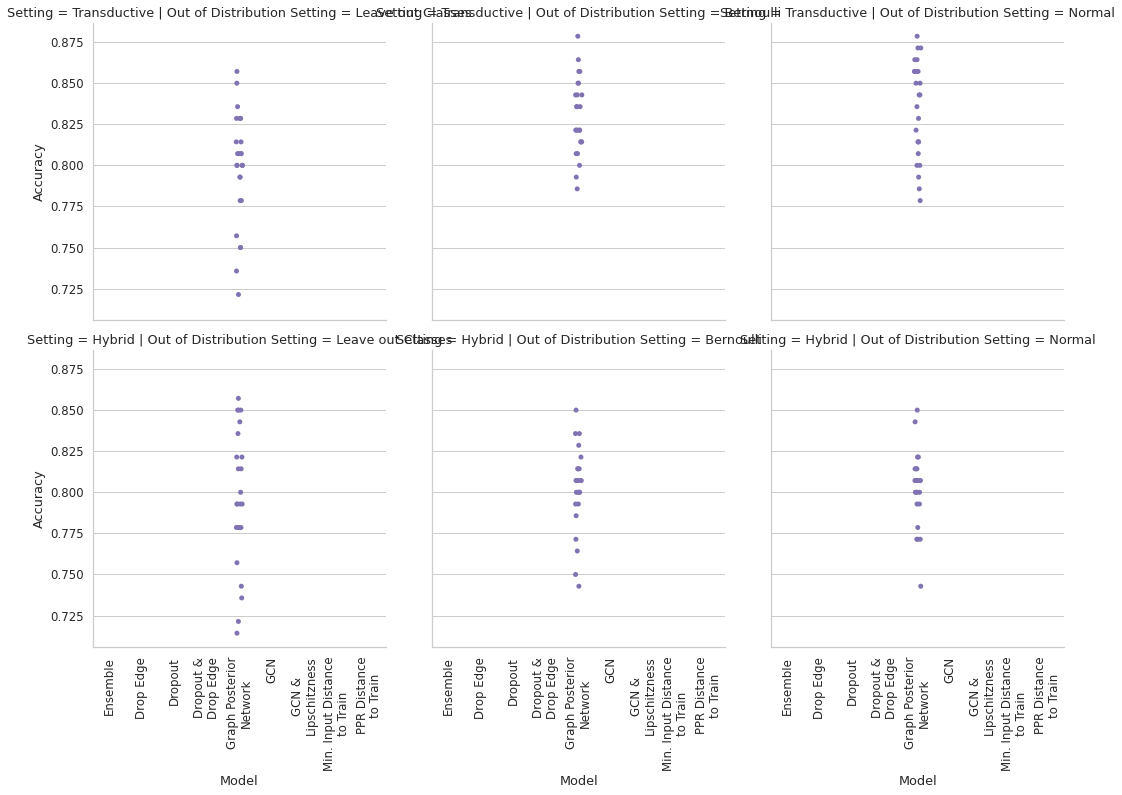

In [29]:
grid = sns.catplot(data = df, x = MODEL, y=ACCURACY, row=SETTING, col=OOD)
for axes in grid.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)